### Imports

In [1]:
import os
import sys
import datetime
import pandas as pd 

sys.path.append("C:/Users/SHIRAM/Documents/WSB/")
from wsb import Gather
from dask.distributed import Client as DaskClient

import time
import asyncio, aiohttp
from aiolimiter import AsyncLimiter

import urllib
import requests
from urllib.parse import urlparse, urlencode, parse_qsl

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [29]:
gather = Gather()

### ETL

#### Submissions

In [46]:
submission_status_df = gather.get_submission_status_mat_view(local=True)

## We're only interested in things from 2019-Jun
start_date = "2019-06-01"
date_range = [x for x in pd.date_range(start=start_date, end="2021-08-29")]
dates_in_submissions = submission_status_df.loc[submission_status_df["date"] > "2019-06-01", "date"]
a = submission_status_df.loc[submission_status_df["date"] >= "2019-06-01", "date"].values

# For missing_start_end_dates
missing_dates = list(set(date_range) - set([pd.to_datetime(x) for x in a]))
missing_start_end_dates = [ (int( (x - pd.Timedelta(days=1)).timestamp() ), int( (x + pd.Timedelta(days=1)).timestamp() )) for x in missing_dates]

In [49]:
submission_status_df

,date,all_submissions_found
0,2012-05-08,[tcup4]
1,2012-06-02,[ugg29]
2,2012-06-04,[ukwhl]
3,2012-06-22,[verkm]
4,2012-07-12,[wextd]
...,...,...
2148,2021-08-24,"[pafmhn, pak91h, pakxqq, pan27h, pankti, patkp..."
2149,2021-08-25,"[pazmes, pb2qes, pb7z51, pb840r, pb8ucz, pbaay..."
2150,2021-08-26,"[pbp39y, pbrvwb, pbwdez, pbxa9w, pc0w0t, pc4k3..."
2151,2021-08-27,"[pccm7x, pcdhe9, pcdlhe, pcdvop, pceppl, pcfvr..."


In [48]:
sorted(missing_dates)

[Timestamp('2021-02-05 00:00:00', freq='D'),
 Timestamp('2021-02-06 00:00:00', freq='D'),
 Timestamp('2021-03-01 00:00:00', freq='D'),
 Timestamp('2021-03-06 00:00:00', freq='D'),
 Timestamp('2021-03-18 00:00:00', freq='D'),
 Timestamp('2021-03-19 00:00:00', freq='D'),
 Timestamp('2021-03-20 00:00:00', freq='D'),
 Timestamp('2021-03-21 00:00:00', freq='D'),
 Timestamp('2021-03-22 00:00:00', freq='D'),
 Timestamp('2021-03-23 00:00:00', freq='D'),
 Timestamp('2021-03-24 00:00:00', freq='D'),
 Timestamp('2021-03-25 00:00:00', freq='D'),
 Timestamp('2021-03-26 00:00:00', freq='D'),
 Timestamp('2021-04-10 00:00:00', freq='D'),
 Timestamp('2021-04-11 00:00:00', freq='D'),
 Timestamp('2021-04-12 00:00:00', freq='D'),
 Timestamp('2021-04-13 00:00:00', freq='D'),
 Timestamp('2021-08-29 00:00:00', freq='D')]

<AxesSubplot:xlabel='date'>

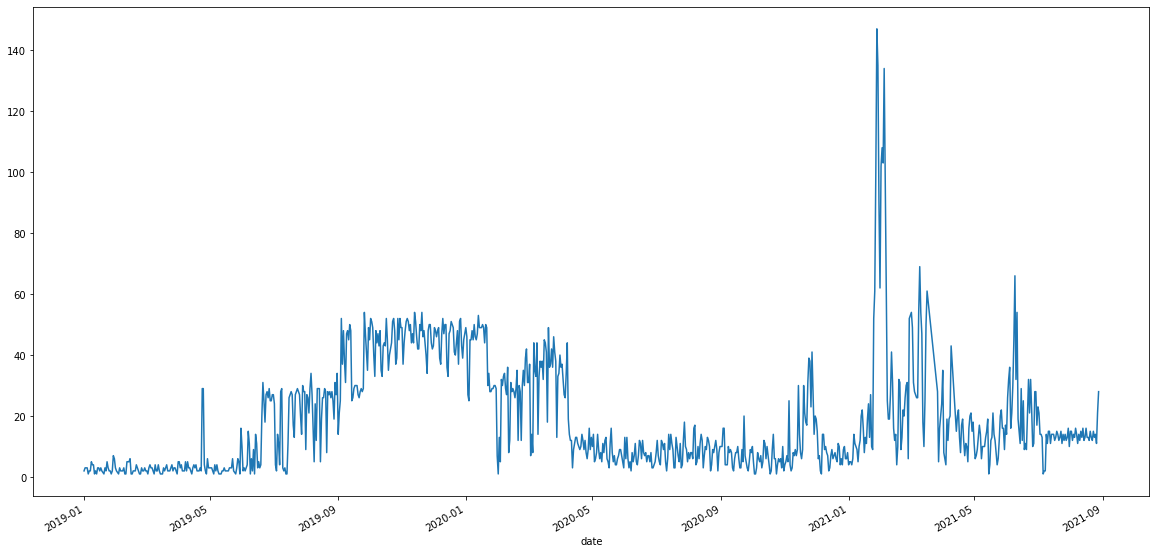

In [45]:
submission_status_df = gather.get_submission_status_mat_view(local=True)
submission_status_df = submission_status_df.set_index("date")
submission_status_df = submission_status_df[submission_status_df.index >= "2019-01-01"]

fig, ax = plt.subplots(figsize=(20, 10))
submission_status_df.loc[:, "all_submissions_found"].apply(lambda x: len(x)).plot(ax=ax)

In [4]:
reddit = gather.get_praw_client()
reddit_pushshift_client = gather.get_pushshift_client()

In [ ]:
https://api.pushshift.io/reddit/search/submission/?q=&after=1559347200&before=1559433600&subreddit=wallstreetbets&author=&aggs=&metadata=true&frequency=hour&advanced=false&sort=desc&domain=&sort_type=num_comments&size=100

In [49]:
start, end = int(date_range[0].timestamp()), int(date_range[1].timestamp())
base_url = "https://api.pushshift.io/reddit/search/submission/?"
params = {
    "after": start, 
    "before": end, 
    "subreddit": "wallstreetbets", 
    "sort_type": "num_comments", 
    "sort": "desc"
}

In [50]:
parsed = urlparse(base_url)
params = urlencode(params)
parsed = parsed._replace(query=params)

In [51]:
result = requests.get(url=parsed.geturl())

#### Comments

In [5]:
submission_comments_status_df, submission_comments_counts_df = gather.get_submission_comments_status_mat_view(local=True)
# submission_comments_status_df = submission_comments_status_df.set_index("date")
# submission_comments_status_df = submission_comments_status_df[submission_comments_status_df.index >= "2019-01-01"]

# fig, ax = plt.subplots(figsize=(20, 10))
# submission_status_df.loc[:, "all_submissions_found"].apply(lambda x: len(x)).plot(ax=ax)

In [10]:
submission_comments_status_df.loc["2019-01-01":, "submission_id"].values

array(['abb8xi', 'ablzh6', 'abb8xi', ..., 'mqolln', 'nu8o4x', 'o6xtko'],
      dtype=object)

In [23]:
import numpy as np

In [25]:
submission_comments_status_df.loc[:, "comments_len"] = submission_comments_status_df["all_comments_found"].apply(lambda x: len(np.unique(x)) )

submission_comments_count_df = pd.DataFrame(
    submission_comments_status_df.groupby([submission_comments_status_df.index]).apply(lambda x: x["comments_len"].sum()), 
    columns=["submission_comments_count"]
)

submission_comments_count_df.plot()

In [29]:
submission_comments_count_df.reset_index()

,date,submission_comments_count
0,2019-01-01,458
1,2019-01-02,4455
2,2019-01-03,4294
3,2019-01-04,4911
4,2019-01-05,16
...,...,...
921,2021-08-08,7
922,2021-08-09,7
923,2021-08-10,8
924,2021-08-11,13


### Experiment with flow

In [12]:
import requests
import asyncio
from wsb import Gather
from tqdm.auto import tqdm
from etl import extract_comments_ids_and_make_urls, extract_comments

In [3]:
loop = asyncio.get_running_loop()

In [4]:
all_comments_urls = loop.create_task(extract_comments_ids_and_make_urls(start_date="2019-01-01", end_date="2019-03-01"))

Searching for comments, within submissions:   0%|          | 0/201 [00:00<?, ?it/s]

In [15]:
all_comments_urls = all_comments_urls.result()

In [18]:
all_responses = []
for url in tqdm(all_comments_urls):
    response = requests.get(url)
    
    if response.status_code == 200: 
        all_responses.append(response)

  0%|          | 0/5667 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
submission_comments_status_df, submission_comments_counts_df = gather.get_submission_comments_status_mat_view(local=True)
submission_comments_counts_df = submission_comments_counts_df.set_index("date")
df_ = submission_comments_status_df.loc[submission_comments_status_df.index > "2021-01-01", ]

<AxesSubplot:xlabel='date'>

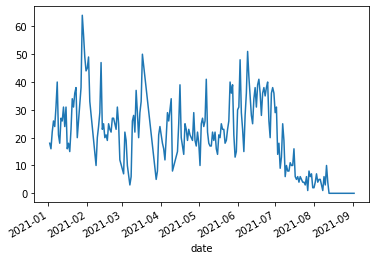

In [47]:
df_.groupby(df_.index).submission_id.count().plot()